### Implementation of DCGANS

In [134]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [135]:
(train_x,train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()

In [136]:
print('The number of samples in the training dataset:', train_x.shape)
print('The number of samples in the test dataset:', test_x.shape)

The number of samples in the training dataset: (60000, 28, 28)
The number of samples in the test dataset: (10000, 28, 28)


since we are interseted in unsupervised training(GANs), ignoring the target labels

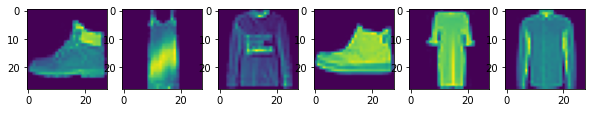

In [137]:
#Display some of the images from the fashion_mnist dataset
plt.figure(figsize=(10,5))

j=0
for i in [90,91,92,93,94,95]:
  j += 1
  plt.subplot(1,6, j)
  plt.imshow(train_x[i])

#### let's use DCGANs to generate these images.
##### we will use the same architecture suggested in the origina paper except the changing the input dimension

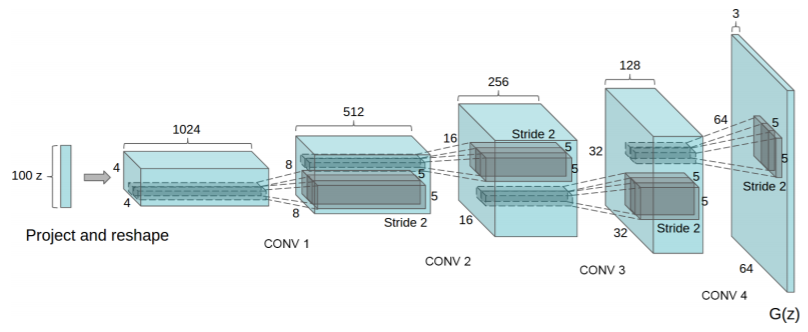

In [138]:
#As the shape of the actual image is 1x28x28 we want the generator also produce the same outcome.
#Accordingly we can change the filter sizes/strides

#define the Generator - activation used is relu and the final layer tanh
def Generator():
  generator = keras.models.Sequential()

  generator.add(keras.layers.Dense(7*7*128, input_shape=(100,)))
  generator.add(layers.Reshape((7, 7, 128)))

  generator.add(layers.BatchNormalization())
  generator.add(layers.ReLU())
  generator.add(layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=2, padding='same'))

  generator.add(layers.BatchNormalization())
  generator.add(layers.ReLU())
  generator.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=2, padding='same'))

  generator.add(layers.BatchNormalization())
  generator.add(layers.ReLU())
  generator.add(layers.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=1, padding='same'))

  generator.add(layers.BatchNormalization())
  generator.add(layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1, padding='same', activation='tanh'))
    
  return generator

In [139]:
Generator().summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_30 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_33 (ReLU)              (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_133 (Conv2D (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_137 (Bat (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_34 (ReLU)              (None, 14, 14, 128)     

In [190]:
#defining the Discriminator
#The activation function used is LeakyReLU
def Discriminator():
  discriminator = tf.keras.models.Sequential()

  discriminator.add(layers.Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding='same', input_shape=[28, 28, 1]))
  discriminator.add(layers.LeakyReLU(alpha=0.2))
  discriminator.add(layers.Dropout(0.3))  

  discriminator.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding='same'))
  discriminator.add(layers.LeakyReLU(alpha=0.2))
  discriminator.add(layers.Dropout(0.3))

  discriminator.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=2, padding='same'))
  discriminator.add(layers.LeakyReLU(alpha=0.2))
  discriminator.add(layers.Dropout(0.3))

  discriminator.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same'))
  discriminator.add(layers.LeakyReLU(alpha=0.2))
  discriminator.add(layers.Dropout(0.3))

  discriminator.add(layers.Flatten())

  discriminator.add(layers.Dense(1, activation='sigmoid'))

  return discriminator

In [191]:
Discriminator().summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 4, 4, 128)       

Now we have built separate the Generator and Discriminator. The next step is to create Adversarial Network. As per the GANs principle, the discriminator is trained separately and while the Generator is learning the weights of the discriminator is frozen.

In [192]:
def build_models():
    
    lr = 2e-4
    decay = 6e-8
    
    base_discriminator = Discriminator()
    
    #The discriminator is compiled separately because it needs to be trained independent of the generator
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #call the generator
    generator = Generator()
    
    #freeze the discriminator for adversarial training
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    
    frozen_discriminator.trainable = False

    #Create Adversarial Network(including Generator + Frozen Discriminator)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

In [193]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(4,4))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

In [198]:
def train_process(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    
    
    (train_x,train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()
    
    #standardize the training input
    train_x = train_x.astype('float32') / 255
    
    #for generator random noise is given as input
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])
    
    #Start training
    for i in range(train_steps):
        
        #Step1: use a random noise as input and get the fake images
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        fake_images = generator.predict(noise_input)
        
        #Step2: Pass the actual images, the images are randomly selected
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        real_images = real_images.reshape(batch_size, 28, 28, 1)
        
        #Step3. Now we combine the fake and real into one single dataset
        X = np.concatenate((real_images, fake_images))
        

        #Step4. Create labels for the fake and real
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #Step5. Train the discriminator
        discri_loss, discri_acc = discriminator.train_on_batch(X, y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Create a new batch of noise
        X = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        
        #2. Since the Discriminator is frozen, we keep all the target labels as 1
        #   The learning happens only for the Generator
        y = np.ones((batch_size, 1))

        adversarial_loss, adversarial_accuracy = adversarial.train_on_batch(X, y)
        
        if i % 1000 == 0:            
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, discri_loss, discri_acc, adversarial_loss, adversarial_accuracy) )
            
            #For every 1000 epochs check for the prediction improvement of the generator
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            plot_images(fake_images, i+1)

In [199]:
G, D, A = build_models()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [200]:
A.summary()

Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73_input (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
dense_73 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_43 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_188 (Bat (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_72 (ReLU)              (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_185 (Conv2D (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_189 (Bat (None, 14, 14, 128)       512

0 [Discriminator loss: 0.691351, acc: 0.632812, Adversarial loss: 0.518205, acc: 1.000000]


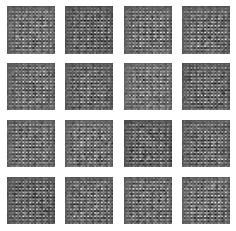

1000 [Discriminator loss: 0.004409, acc: 1.000000, Adversarial loss: 7.175160, acc: 0.000000]


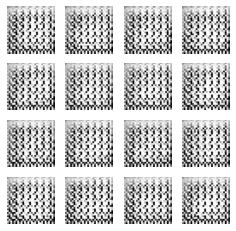

2000 [Discriminator loss: 0.003444, acc: 1.000000, Adversarial loss: 0.035225, acc: 0.984375]


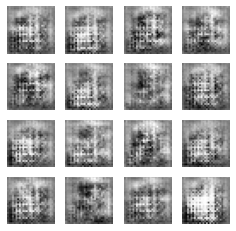

3000 [Discriminator loss: 0.000916, acc: 1.000000, Adversarial loss: 6.716355, acc: 0.000000]


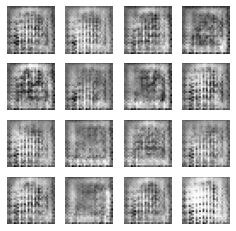

4000 [Discriminator loss: 0.006516, acc: 1.000000, Adversarial loss: 0.155851, acc: 0.937500]


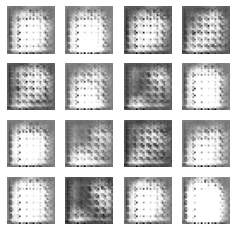

5000 [Discriminator loss: 0.007008, acc: 0.992188, Adversarial loss: 2.489045, acc: 0.390625]


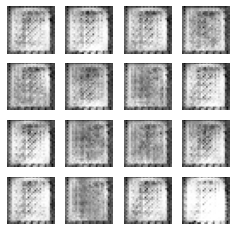

6000 [Discriminator loss: 0.041847, acc: 0.984375, Adversarial loss: 3.056517, acc: 0.234375]


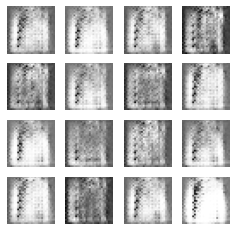

7000 [Discriminator loss: 0.038098, acc: 0.992188, Adversarial loss: 1.678469, acc: 0.421875]


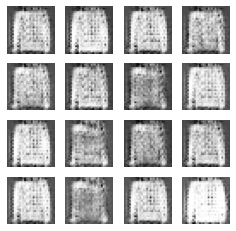

8000 [Discriminator loss: 0.119352, acc: 0.953125, Adversarial loss: 9.589682, acc: 0.000000]


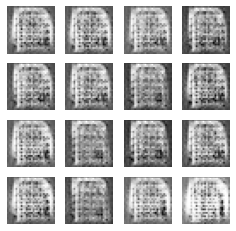

9000 [Discriminator loss: 0.000336, acc: 1.000000, Adversarial loss: 0.044097, acc: 0.984375]


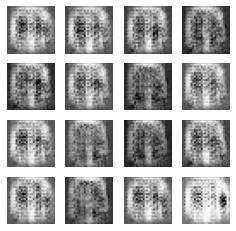

In [201]:
train_process(G, D, A)